# CS441: Applied ML - HW 2

### Part 1: Model Complexity and Tree-based Regressors

Include all the code for Part 1 in this section

In [ ]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  drive.mount('/content/drive')
  datadir = "/content/drive/My Drive/CS441/hw2/" 
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target temperature
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()

# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()

Mounted at /content/drive


In [ ]:
# to plot the errors
def plot_depth_error(max_depths, tree_train_err, tree_val_err, rf_train_err, rf_val_err, bt_train_err, bt_val_err):
  plt.figure(figsize=(15,15))
  plt.semilogx(max_depths, tree_train_err, 'r.--',label='tree train')
  plt.semilogx(max_depths, tree_val_err, 'r.-', label='tree val')
  plt.semilogx(max_depths, rf_train_err, 'g.--',label='RF train')
  plt.semilogx(max_depths, rf_val_err, 'g.-', label='RF val')
  plt.semilogx(max_depths, bt_train_err, 'b.--',label='BT train')
  plt.semilogx(max_depths, bt_val_err, 'b.-', label='BT val')
  plt.ylabel('RMSE Error')
  plt.xlabel('Max Tree Depth')
  plt.xticks(max_depths, max_depths)
  plt.legend()
  plt.rcParams.update({'font.size': 20})
  plt.show()

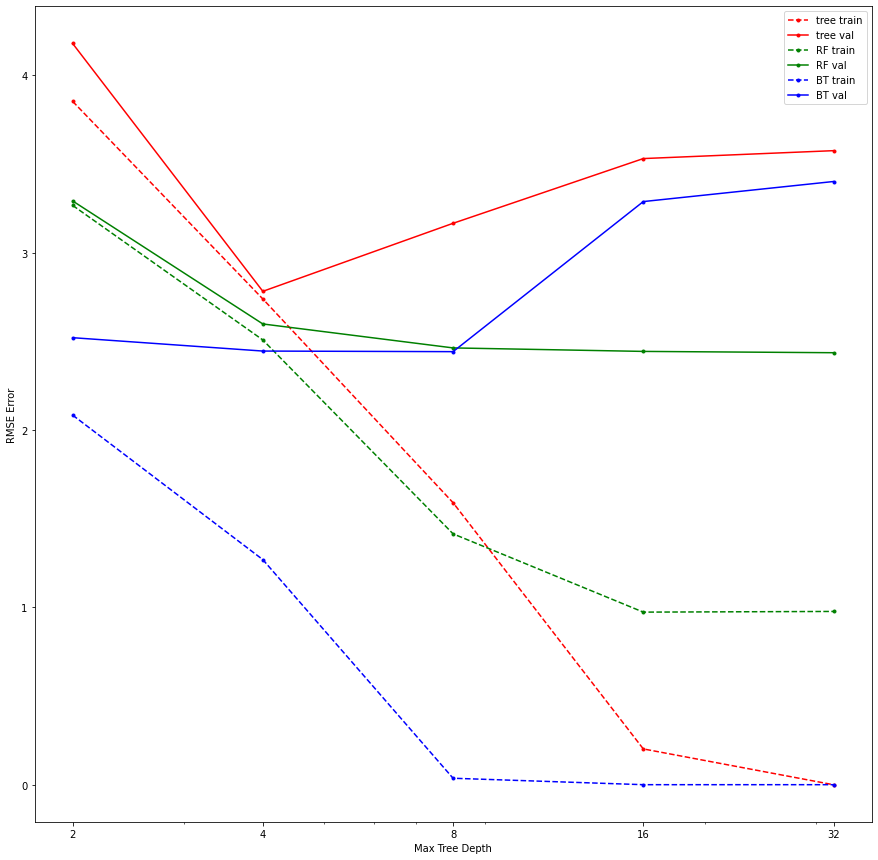

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

max_depths = [2,4,8,16,32]

train_rmse_tree, val_rmse_tree = [],[]
train_rmse_rf, val_rmse_rf = [],[]
train_rmse_bt, val_rmse_bt = [],[]

for max_depth in max_depths:
  # Decision Tree
  tree = DecisionTreeRegressor(random_state=0, max_depth=max_depth)
  tree.fit(x_train, y_train)
  y_train_pred = tree.predict(x_train)
  y_val_pred = tree.predict(x_val)
  train_rmse_tree.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
  val_rmse_tree.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

  # Random Forest
  rf = RandomForestRegressor(random_state=0, max_depth=max_depth, max_features=1/3)
  rf.fit(x_train, y_train)
  y_train_pred = rf.predict(x_train)
  y_val_pred = rf.predict(x_val)
  train_rmse_rf.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
  val_rmse_rf.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

  # Gradient Boosted Tree
  bt = GradientBoostingRegressor(random_state=0, max_depth=max_depth)
  bt.fit(x_train, y_train)
  y_train_pred = bt.predict(x_train)
  y_val_pred = bt.predict(x_val)
  train_rmse_bt.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
  val_rmse_bt.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

plot_depth_error(max_depths, train_rmse_tree, val_rmse_tree, train_rmse_rf, val_rmse_rf, train_rmse_bt, val_rmse_bt)


### Part 2: MLPs with MNIST

Include all the code for Part 2 in this section

In [2]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import torch.optim as optim

# loads MNIST data and reformat to 768-d vectors with values in range 0 to 1
# splits into train/val/test sets and provides indices for subsets of train
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
  x_train = np.reshape(x_train, (len(x_train), 28*28))
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval
  x_test = x_test/maxval
  x_val = x_train[:10000]
  y_val = y_train[:10000]
  x_train = x_train[10000:]
  y_train = y_train[10000:]
  train_indices = dict()
  train_indices['xs'] = np.arange(50)
  train_indices['s'] = np.arange(500)
  train_indices['m'] = np.arange(5000)
  train_indices['all'] = np.arange(50000)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices

# displays a set of mnist images
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

# counts the number of examples per class
def class_count_mnist(y):
  count = np.zeros((10,),dtype='uint32')
  for i in np.arange(10):
    count[i] = sum(y==i)
  return count

In [3]:
(x_train, y_train), (x_val, y_val), (x_test, y_test), train_indices = load_mnist()

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
# Sets device to "cuda" if a GPU is available  (in Colabs, enable GPU by Edit->Notebook Settings-->Hardware Accelerator=GPU)
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [5]:
def display_error_curves(num_epochs, training_losses, validation_losses):
  """
  Plots the training and validation loss curves
  """

  plt.plot(range(num_epochs), training_losses, label="Training Loss")
  plt.plot(range(num_epochs), validation_losses, label="Validation Loss")

  # Add in a title and axes labels
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  
  # Display the plot
  plt.legend(loc='best')
  plt.show()
  plt.show()

In [7]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(MLP, self).__init__()   
        self.layers = torch.nn.Sequential(
          torch.nn.Linear(input_size, hidden_size1),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_size1, hidden_size2),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_size2, hidden_size3),
          torch.nn.ReLU(),
          torch.nn.Linear(hidden_size3, output_size)
       )
    def forward(self, x):
      return self.layers(x)

In [14]:
# This is a possible function definition for training MLP, but feel free to change it
def train_MLP_mnist(train_loader, val_loader, test_loader, lr=0.001, num_epochs=100):
  '''
  Train a MLP 
  Input: X[i] is the ith training data. y[i] is the ith training label. alpha is the count prior
  Output: return a trained MLP
  '''
  # needs code here
  input_size = 28*28
  hidden_size1 = 512
  hidden_size2 = 256
  hidden_size3 = 128
  output_size = 10

  # Instantiate the model
  mlp = MLP(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(mlp.parameters(), lr=lr)

  train_losses = []
  val_losses = []
  train_err = []
  val_error = []

  for epoch in range(0, num_epochs):
    # Training phase
    train_loss = 0
    train_wrong = 0
    train_count = 0
    for i, data in enumerate(train_loader):    
      inputs, targets = data # Get inputs  
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      loss = criterion(outputs, targets) # Compute loss
      loss.backward() # Backprop loss
      optimizer.step() # Update weights
      
      train_loss += loss.item()
      predictions = outputs.argmax(dim=1, keepdim = True)
      train_wrong += predictions.ne(targets.argmax(dim=1).view_as(predictions)).sum().item()
      train_count += targets.shape[0]

    # Compute average training loss and training error for the epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    curr_err_train = 100 * (train_wrong / train_count)
    train_err.append(curr_err_train)

    # Validation phase
    val_loss = 0
    count = 0
    wrong = 0

    with torch.no_grad():
      for x, y in val_loader:
        y_pred = mlp(x)
        loss = criterion(y_pred, y.argmax(dim=1)).item()
        val_loss += loss
        predictions = y_pred.argmax(dim=1, keepdim=True)
        wrong += predictions.ne(y.argmax(dim=1).view_as(predictions)).sum().item()
        count += y.shape[0]

    # Compute average validation loss and accuracy for the epoch
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_error_curr = 100 * (wrong/count)
    val_error.append(val_error_curr)

    #Testing phase
    test_wrong = 0
    test_count = 0
    for i, data in enumerate(test_loader):    
      inputs, targets = data # Get inputs  
      optimizer.zero_grad() # Zero the gradients
      outputs = mlp(inputs) # Compute logit scores for current batch
      
      predictions = outputs.argmax(dim=1, keepdim = True)
      test_wrong += predictions.ne(targets.argmax(dim=1).view_as(predictions)).sum().item()
      test_count += targets.shape[0]
    curr_err_test = 100 * (test_wrong / test_count)

    # Print the losses and validation error
    if (epoch+1) % 25 == 0 or epoch == 0:
      print(str(epoch+1) + " " + str(num_epochs) + " " +  str(train_losses[epoch]) + " " + str(curr_err_train) + " " + str(val_losses[epoch]) + " " + str(val_error_curr) + " " + str(curr_err_test))
    
  display_error_curves(num_epochs, train_losses, val_losses)

In [13]:
# experiments code
print(device) # make sure you're using GPU instance
torch.manual_seed(0) # to avoid randomness, but if you wanted to create an ensemble, you should not use a manual seed
# x_train_tensor = torch.Tensor(x_train)
# y_train_tensor = torch.Tensor(np.eye(10)[y_train])
trainset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(np.eye(10)[y_train]))
valset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(np.eye(10)[y_val]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=False)

testset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(np.eye(10)[y_test]))
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

train_MLP_mnist(train_loader, val_loader, test_loader)

cuda
1 200 0.45279471454571707 12.922 0.19249908160418272 5.7700000000000005 5.45
25 200 0.008883731326115632 0.32399999999999995 0.09420320195831663 1.87 2.1
50 200 4.542787021294743e-06 0.0 0.10776840273755824 1.54 1.68
75 200 2.967617776732243e-07 0.0 0.12832512638997282 1.51 1.6400000000000001
100 200 2.1234609915670484e-08 0.0 0.1509566189488396 1.47 1.67
125 200 1.4349968740206768e-09 0.0 0.17194505189545453 1.4500000000000002 1.67
150 200 6.17713915732462e-11 0.0 0.17817671099910512 1.43 1.67
175 200 0.003947828490727633 0.108 0.1012735491854528 2.06 1.6500000000000001


KeyboardInterrupt: ignored

## Part 3: Predicting Penguin Species

Include all your code for part 3 in this section.  

In [2]:
import numpy as np
from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
#styling preferences for sns
sns.set_style('whitegrid')
sns.set_context('poster')
drive.mount('/content/gdrive/')
datadir = "/content/gdrive/MyDrive/CS441/hw2/" 
df_penguins = pd.read_csv(datadir + 'penguins_size.csv')
df_penguins.head(10)

def get_penguin_xy(df_penguins):
  data = np.array(df_penguins[['island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']])
  y = df_penguins['species']
  ui = np.unique(data[:,0])
  us = np.unique(data[:,-1])
  X = np.zeros((len(y), 10))
  for i in range(len(y)):
    f = 0
    for j in range(len(ui)):
      if data[i, f]==ui[j]:
        X[i, f+j] = 1
    X[i, 3:7] = data[i, 1:5]
    for j in range(len(us)):
      if data[i, 5]==us[j]:
        X[i, f+j] = 1
  feature_names = ['island_biscoe', 'island_dream', 'island_torgersen', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex_female', 'sex_male', 'sex_unknown']
  X = pd.DataFrame(X, columns=feature_names)
  return(X, y, feature_names, np.unique(y))


Mounted at /content/gdrive/


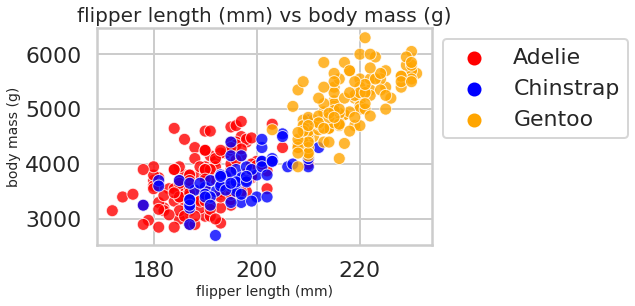

In [5]:
palette = ["red", "blue", "orange"]

# https://seaborn.pydata.org/generated/seaborn.scatterplot.html
sns.scatterplot(data=df_penguins, x = 'flipper_length_mm', y = 'body_mass_g', 
               hue = 'species', palette=palette, alpha=0.8)

plt.xlabel('flipper length (mm)', fontsize=14)
plt.ylabel('body mass (g)', fontsize=14)
plt.title('flipper length (mm) vs body mass (g)', fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.show()

# create other visualizations


[Text(0.5, 0.8333333333333334, 'flipper_length_mm <= 206.5\ngini = 0.636\nsamples = 341\nvalue = [151, 68, 122]\nclass = Adelie'),
 Text(0.25, 0.5, 'culmen_length_mm <= 43.35\ngini = 0.423\nsamples = 213\nvalue = [149, 63, 1]\nclass = Adelie'),
 Text(0.125, 0.16666666666666666, 'gini = 0.064\nsamples = 150\nvalue = [145, 5, 0]\nclass = Adelie'),
 Text(0.375, 0.16666666666666666, 'gini = 0.148\nsamples = 63\nvalue = [4, 58, 1]\nclass = Chinstrap'),
 Text(0.75, 0.5, 'culmen_depth_mm <= 17.65\ngini = 0.105\nsamples = 128\nvalue = [2, 5, 121]\nclass = Gentoo'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 121\nvalue = [0, 0, 121]\nclass = Gentoo'),
 Text(0.875, 0.16666666666666666, 'gini = 0.408\nsamples = 7\nvalue = [2, 5, 0]\nclass = Chinstrap')]

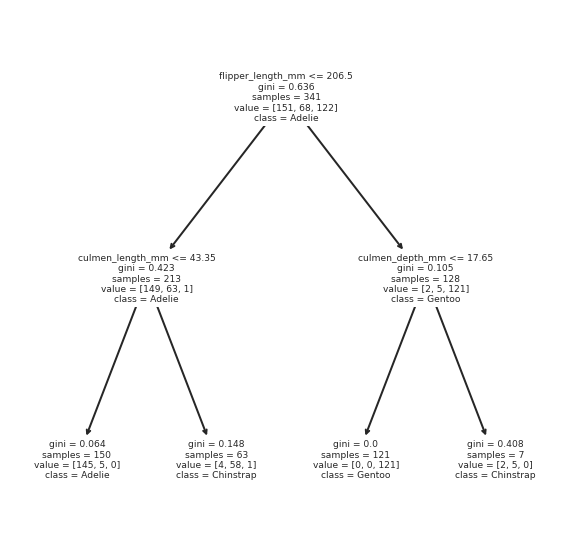

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

X,y, feature_names, class_names = get_penguin_xy(df_penguins)
model = DecisionTreeClassifier(max_depth = 2)
model.fit(X,y)

fig, ax = plt.subplots(figsize=(10,10))
plot_tree(model, feature_names = feature_names, class_names = class_names)

In [15]:
# design a classification model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X, y, feature_names, class_names = get_penguin_xy(df_penguins)

model = RandomForestClassifier(max_depth = 5)
model.fit(X,y)

scores = cross_val_score(model, np.array(X), np.array(y), cv=5)
print('CV Accuracy: {}'.format(scores.mean()))

CV Accuracy: 0.9911764705882353


## Part 4: Stretch Goals
Include any new code needed for Part 4 here